# **LAIDD 차원축소 강의 실습자료**

*   **Lecturer**: Sangsoo Lim
*   **e-mail**: sslim@dgu.ac.kr

**Methods to Learn**:

*   PCA
*   tSNE
*   LDA
*   CCA
*   Autoencoder
*   MOFA

**References**:

*   https://www.kaggle.com/code/pippyb/mo-tutorial-notebook-example
*   https://colab.research.google.com/github/ML-Challenge/week4-unsupervised-learning/blob/master/L3.Decorrelating%20data%20and%20dimension%20reduction.ipynb#scrollTo=qnL6Dd7XROLq
*   https://caam37830.github.io/book/07_data/dimension_reduction.html
*   https://colab.research.google.com/drive/1CiIHRMIQTxKD0GzVGE1lf8nu6qbxioXl#scrollTo=AKMrB38RMVIS
*   https://muon-tutorials.readthedocs.io/en/latest/CLL.html


# **0. Import Libraries**

## 0-1. Setup

In [253]:
!pip install scanpy

In [254]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [255]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [256]:
# Import more libraries
from sklearn.linear_model import LinearRegression
from scipy.stats import ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import scanpy as sc

import plotly
import plotly.graph_objects as go
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from sklearn import preprocessing

from sklearn.preprocessing import LabelEncoder

# **1. Simple Practice on Individual Methods**

## 1-0. Preparation of synthetic dataset

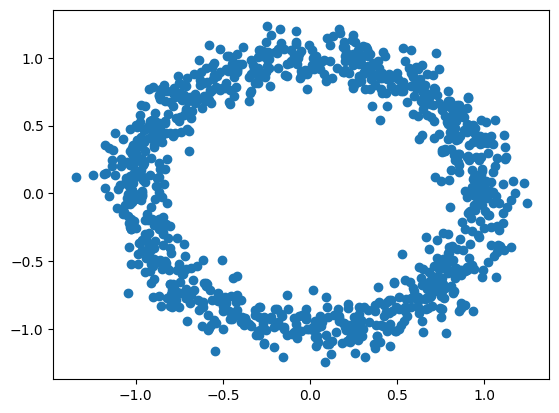

In [257]:
def sample_noisy_sphere(n, k=1, sigma=0.1):
    """
    Sample n points uniformly at random from the k-sphere
    embedded in k+1 dimensions

    Add normal nosie with variance sigma
    """
    d = k+1  # dimension of space

    X = np.random.randn(n,d)
    X = X / np.linalg.norm(X, axis=1).reshape(n,-1) # project onto sphere

    return X + sigma*np.random.randn(n,d)


X = sample_noisy_sphere(1000)

plt.scatter(X[:,0], X[:,1])
plt.show()

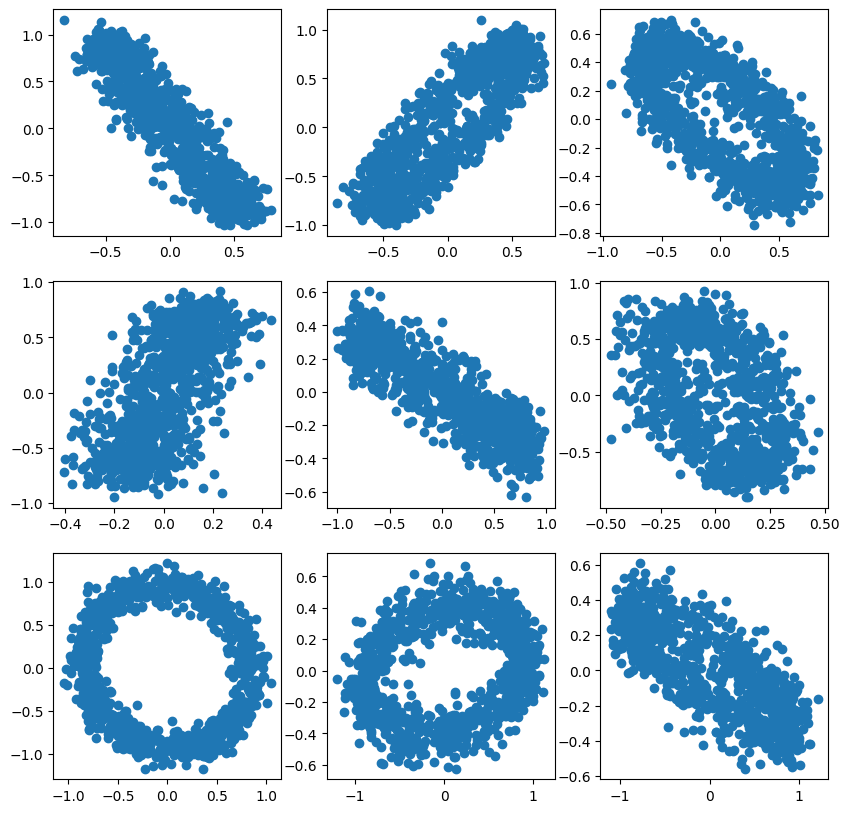

In [259]:
def sample_noisy_sphere(n, **kw):
    """
    Sample n points uniformly at random from the k-sphere
    embedded in d dimensions.

    Add normal noise with variance sigma

    Arguments:
        n - number of samples

    Optional arguments:
        r - radius of circle (default 1.0)
        k - dimension of sphere (default k = 1 == circle)
        sigma - noise variance (default 0.1)
        d - dimension of embedded space (default k+1)
    """
    r = kw.get('r', 1.0)
    k = kw.get('k', 1)
    sigma = kw.get('sigma', 0.1)
    d = kw.get('d', k+1)

    X = np.random.randn(n,k+1)
    X = r * X / np.linalg.norm(X, axis=1).reshape(n,-1) # project onto sphere

    Q, R = np.linalg.qr(np.random.randn(d, k+1))
    X = X @ Q.T # apply random rotation

    return X + sigma*np.random.randn(n,d)

m, n = 3,3
fig, ax = plt.subplots(m,n, figsize=(10,10))
for i in range(m):
    for j in range(n):
        X = sample_noisy_sphere(1000, d=5)

        ax[i,j].scatter(X[:,0], X[:,1])

plt.show(fig)

In [260]:
import plotly
import plotly.graph_objects as go

In [261]:
X = sample_noisy_sphere(1000, d=3)
fig = go.Figure(data=[go.Scatter3d(x=X[:,0], y=X[:,1], z=X[:,2],
                                   mode='markers', marker=dict(size=1))])
fig.show()

In [262]:
def quick_scatter(X):
    fig = go.Figure(data=[go.Scatter3d(x=X[:,0], y=X[:,1], z=X[:,2],
                                   mode='markers',marker=dict(size=1))])
    fig.show()

## 1-1. Principal Component Anslysis via Singular Value Decomposition

*  필요한 라이브러리: numpy, matplotlib

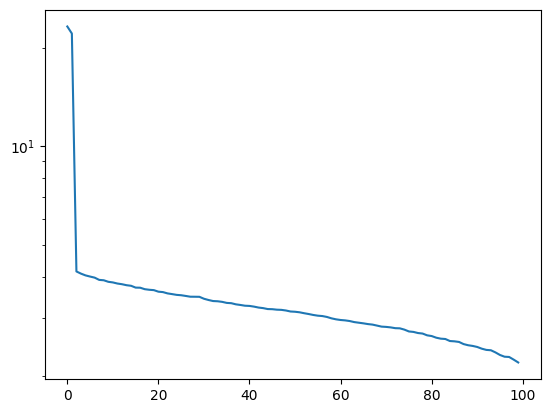

In [263]:
X = sample_noisy_sphere(1000, d=100, sigma=0.1)
u, s, v = np.linalg.svd(X)
plt.semilogy(s)
plt.show()

In [264]:
s

array([23.19687828, 22.0759192 ,  4.15500684,  4.09159309,  4.04142283,
        4.00861857,  3.97836717,  3.91607161,  3.90562241,  3.86378871,
        3.8467559 ,  3.81716967,  3.79883667,  3.77251172,  3.75712701,
        3.70954354,  3.70673325,  3.66862303,  3.65342257,  3.64414743,
        3.604986  ,  3.59436566,  3.56181775,  3.5441134 ,  3.52508792,
        3.51597691,  3.49849455,  3.47998538,  3.47891869,  3.47741024,
        3.43040699,  3.40046272,  3.37564896,  3.37024902,  3.35630901,
        3.33196782,  3.32504184,  3.29856704,  3.28397091,  3.26677745,
        3.26179562,  3.24582206,  3.22439836,  3.21194251,  3.1910252 ,
        3.18801934,  3.17708218,  3.17293446,  3.15881274,  3.13678576,
        3.13110206,  3.11913959,  3.09898907,  3.08137623,  3.06127493,
        3.04602066,  3.03793391,  3.01889447,  2.9894834 ,  2.96885531,
        2.95508662,  2.9470067 ,  2.93344302,  2.91194912,  2.89921147,
        2.88651453,  2.87159075,  2.8611977 ,  2.84113648,  2.82

In [267]:
print(u.shape, s.shape, v.shape)

(1000, 1000) (100,) (100, 100)


In [266]:
print(X.shape)

(1000, 100)


## 1-2. Principal Component Analysis

In [268]:
# Import PCA library
from sklearn.decomposition import PCA
from scipy.stats import pearsonr

In [269]:
# Create PCA instance: model
model = PCA()

In [271]:
# Apply the fit_transform method of model to grains: pca_features
pca_features = model.fit_transform(X)

In [272]:
# Assign 0th column of pca_features: xs
xs = pca_features[:,0]

# Assign 1st column of pca_features: ys
ys = pca_features[:,1]

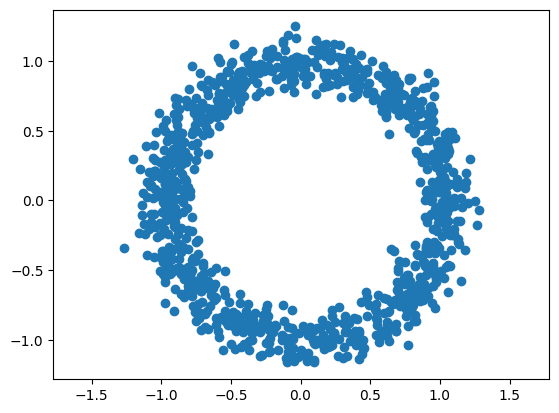

In [273]:
# Scatter plot xs vs ys
plt.scatter(xs, ys)
plt.axis('equal')
plt.show()

In [274]:
# Calculate the Pearson correlation of xs and ys
correlation, pvalue = pearsonr(xs, ys)

# Display the correlation
print(correlation)

-3.3314822255048337e-16


## 1-3. tSNE

In [275]:
import sklearn.manifold as manifold

In [276]:
def nested_spheres(*rs, **kw):
    """
    generate nested circles

    Arguments:
        r1, r2, r3,... radii of circles

    Optional arguments:
        n = number of samples for each circle (default 500)
        additional arguments will be passed to sample_noisy_sphere
    """
    ns = kw.pop('n', 500) # remove key from dict
    if type(ns) is int:
        ns = tuple(ns for r in rs)

    data = []
    for n, r in zip(ns, rs):
        data.append(sample_noisy_sphere(n, r=r, **kw))

    return np.concatenate(data, axis=0)

np.random.seed(1)
X = nested_spheres(1.0, 2.0, 3.0, d=3)
quick_scatter(X)

In [277]:
def f(x):
    y = [x[0]*x[1], x[0] - x[1], np.sin(x[1]), np.cos(x[1])]
    y.extend([x[i] for i in range(2, len(x))])
    return np.array(y)

Y = np.array([f(x) for x in X])
quick_scatter(Y)

In [278]:
transformer = manifold.TSNE(n_components=3, init='pca', random_state=0)
Ytrans = transformer.fit_transform(Y)
quick_scatter(Ytrans)

# **2. Application to biological dataset**

This dataframe consists of a set of four types of omics and five outcomes for the patients. The omics are:

*   mu: Whether a sonamic mutation (i.e., a mutation that happened after conception) is present for a gene.

*   cn: Copy number of a part of the genome (i.e., amount of amplification of a part of the genome, this changes between different cells and individuals).

*   rs: RNA-Seq.

*   pp: Protein levels.

In [279]:
# Open the dataset (dataset retrieved from kaggle)

df = pd.read_csv("https://raw.githubusercontent.com/sslim0814/laidd/main/brca/brca_data_w_subtypes.csv")

# View the first 5 rows
print(df.head())

   rs_CLEC3A    rs_CPB1  rs_SCGB2A2  rs_SCGB1D2    rs_TFF1   rs_MUCL1  \
0   0.892818   6.580103   14.123672   10.606501  13.189237   6.649466   
1   0.000000   3.691311   17.116090   15.517231   9.867616   9.691667   
2   3.748150   4.375255    9.658123    5.326983  12.109539  11.644307   
3   0.000000  18.235519   18.535480   14.533584  14.078992   8.913760   
4   0.000000   4.583724   15.711865   12.804521   8.881669   8.430028   

    rs_GSTM1     rs_PIP  rs_ADIPOQ   rs_ADH1B  ...  pp_p62.LCK.ligand  \
0  10.520335  10.338490  10.248379  10.229970  ...          -0.691766   
1   8.179522   7.911723   1.289598   1.818891  ...           0.279067   
2  10.517330   5.114925  11.975349  11.911437  ...           0.219910   
3  10.557465  13.304434   8.205059   9.211476  ...          -0.266554   
4  12.964607   6.806517   4.294341   5.385714  ...          -0.441542   

   pp_p70S6K  pp_p70S6K.pT389  pp_p90RSK  pp_p90RSK.pT359.S363  vital.status  \
0  -0.337863        -0.178503   0.011638  

In [280]:
df.shape

(705, 1941)

In [281]:
print("Presenting the DataFrame:")
print("")
print("Variables: Four types of omics.")
print("Number of RNAseq variables:",
      len([match for match in df.columns if match.startswith("rs")]))
print("Number of Copy Number variables:",
      len([match for match in df.columns if match.startswith("cn")]))
print("Number of Mutation variables:",
      len([match for match in df.columns if match.startswith("mu")]))
print("Number of Protein variables:",
      len([match for match in df.columns if match.startswith("pp")]))

print("")
print("Outcomes: Five Outcomes.")
print("Vital Status:",df["vital.status"].unique())
print("Progesterone Receptors:",(df["PR.Status"]).unique())
print("Estrogen Receptors:",(df["ER.Status"]).unique())
print("HER2 Status",(df["HER2.Final.Status"]).unique())
print("Histological Cancer Subtype",(df["histological.type"]).unique())

Presenting the DataFrame:

Variables: Four types of omics.
Number of RNAseq variables: 604
Number of Copy Number variables: 860
Number of Mutation variables: 249
Number of Protein variables: 223

Outcomes: Five Outcomes.
Vital Status: [0 1]
Progesterone Receptors: ['Positive' 'Negative' nan 'Performed but Not Available' 'Indeterminate'
 'Not Performed']
Estrogen Receptors: ['Positive' 'Negative' nan 'Performed but Not Available' 'Indeterminate'
 'Not Performed']
HER2 Status ['Negative' nan 'Positive' 'Equivocal' 'Not Available']
Histological Cancer Subtype ['infiltrating ductal carcinoma' 'infiltrating lobular carcinoma']


In [282]:
# Use RNA-seq data
df_rs = df.filter(regex='rs_') # Select columns that contatin 'rs_' using regular expression pattern search.
print(df_rs.shape)

(705, 604)


## 2-1. Singular Value Decomposition

*  필요한 라이브러리: numpy, matplotlib

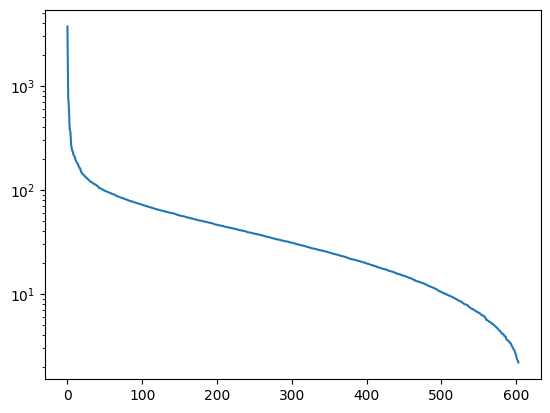

In [283]:
u, s, v = np.linalg.svd(df_rs) # Singular Valud Decomposition using numpy
plt.semilogy(s) # y-axis has log-scale.
plt.show()

In [287]:
print(s[:10])

[3742.43151978  785.60106106  607.96489649  383.16288523  361.33849342
  270.97411129  246.36701485  234.63857159  218.88692521  212.58855294]


In [284]:
print(u.shape, s.shape, v.shape)

(705, 705) (604,) (604, 604)


## 2-2. Principal Component Analysis

In [289]:
# Import PCA library
from sklearn.decomposition import PCA
from scipy.stats import pearsonr

In [290]:
# Create PCA instance: model
model = PCA()

In [291]:
# Apply the fit_transform method of model to grains: pca_features
pca_features = model.fit_transform(df_rs)

In [292]:
# Assign 0th column of pca_features: xs
xs = pca_features[:,0]

# Assign 1st column of pca_features: ys
ys = pca_features[:,1]

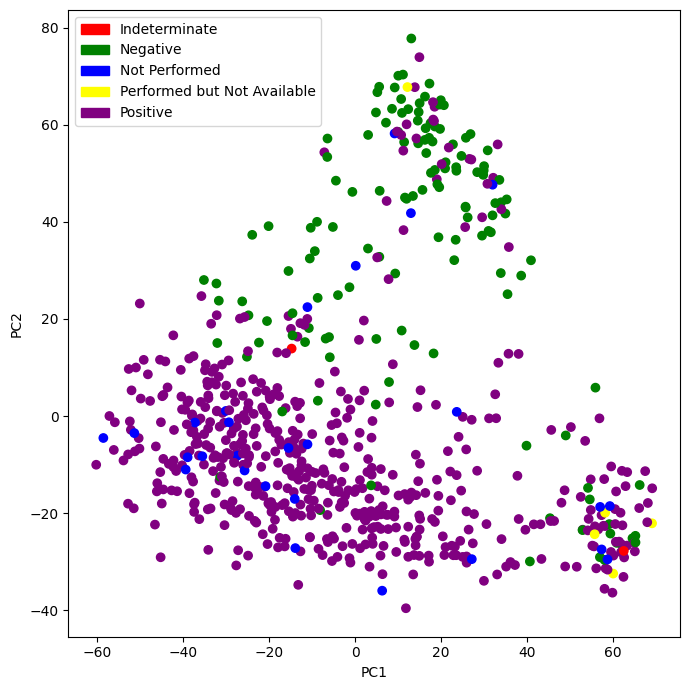

In [293]:
# Scatter plot xs vs ys
le = LabelEncoder()

# Histological Subtype
# le.fit(df["histological.type"])
# c = le.transform(df["histological.type"])

# Vital Status
# c = df["vital.status"]

# ER Status
le.fit(df["ER.Status"])
c = le.transform(df["ER.Status"])
colors = ['red', 'green', 'blue', 'yellow', 'purple']
cmap = ListedColormap(colors)

fig, ax = plt.subplots(figsize=(7,7))
x = xs
y = ys
sc = ax.scatter(x, y, c=c, cmap=cmap)

# Create the legend
labels = le.classes_
legend_handles = [mpatches.Patch(color=color, label=label) for color, label in zip(colors, labels)]
ax.legend(handles=legend_handles)
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.tight_layout()
plt.show()

In [294]:
# Calculate the Pearson correlation of xs and ys
correlation, pvalue = pearsonr(xs, ys)

# Display the correlation
print(correlation)

1.4769544094683784e-16


Variance of PCA features

In [295]:
# Perform the necessary imports
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [296]:
# Create scaler: scaler
scaler = StandardScaler()

In [297]:
# Create a PCA instance: pca
pca = PCA()

In [298]:
# Create pipeline: pipeline
pipeline = make_pipeline(scaler, pca)

In [299]:
# Fit the pipeline to 'samples'
pipeline.fit(df_rs)

Pipeline(steps=[('standardscaler', StandardScaler()), ('pca', PCA())])

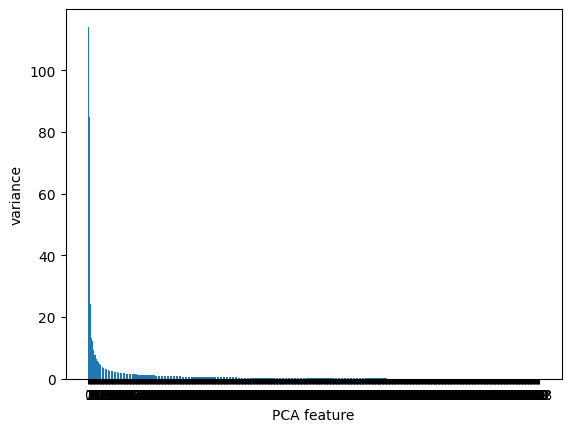

In [300]:
# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

In [303]:
pca.explained_variance_[:10]

array([114.12705333,  84.96085041,  32.32639233,  24.1806956 ,
        13.31736901,  12.13930849,   9.8462611 ,   9.46706819,
         7.84348858,   7.78302369])

-----------------------

## 2-3. tSNE

In [304]:
transformer = manifold.TSNE(n_components=3, init='pca', random_state=0)
df_trans = transformer.fit_transform(df_rs)
quick_scatter(df_trans)

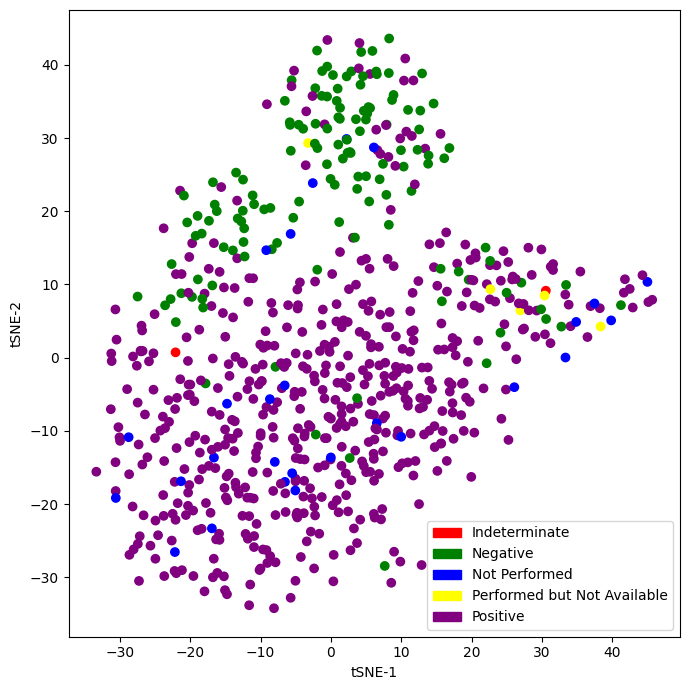

In [305]:
# Histological Subtype
# le.fit(df["histological.type"])
# c = le.transform(df["histological.type"])

# Vital Status
# c = df["vital.status"]

# ER Status
le.fit(df["ER.Status"])
c = le.transform(df["ER.Status"])
colors = ['red', 'green', 'blue', 'yellow', 'purple']
cmap = ListedColormap(colors)

fig, ax = plt.subplots(figsize=(7,7))
x = df_trans[:,0]
y = df_trans[:,1]
sc = ax.scatter(x, y, c=c, cmap=cmap)

# Create the legend
labels = le.classes_
legend_handles = [mpatches.Patch(color=color, label=label) for color, label in zip(colors, labels)]
ax.legend(handles=legend_handles)
plt.xlabel('tSNE-1')
plt.ylabel('tSNE-2')

plt.tight_layout()
plt.show()

## 2-4. LDA

In [306]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [308]:
def lda_transform(data, labels, n_components=2):
    lda = LinearDiscriminantAnalysis(n_components=n_components)
    return lda.fit_transform(data, labels)

In [309]:
le.fit(df["ER.Status"])
c = le.transform(df["ER.Status"])
df_rs_lda = df_rs
df_rs_lda['target'] = c

In [310]:
# Drop rows with NaN values
df_cleaned = df_rs_lda.dropna()
labels_cleaned = df_rs_lda["target"].dropna().values
lda_result = lda_transform(df_cleaned, labels_cleaned, n_components=3)

In [311]:
def quick_scatter(X, color_values):
    fig = go.Figure(data=[go.Scatter3d(
        x=X[:, 0],
        y=X[:, 1],
        z=X[:, 2],
        mode='markers',
        marker=dict(
            size=1,
            color=color_values,  # set color to an array/list of desired values
            colorscale='Viridis',  # choose a colorscale
            opacity=0.8,
            colorbar_title='Color Legend'  # title for the color legend
        )
    )])
    fig.show()

quick_scatter(lda_result, labels_cleaned)


## 2-5. CCA (canonical correlation analysis)

In [312]:
from sklearn.cross_decomposition import CCA

In [314]:
# Assuming df_rs has an even number of columns
mid_idx = df_rs.shape[1] // 2
X = df_rs.iloc[:, :mid_idx]
Y = df_rs.iloc[:, mid_idx:]

In [315]:
cca = CCA(n_components=2)
X_c, Y_c = cca.fit_transform(X, Y)

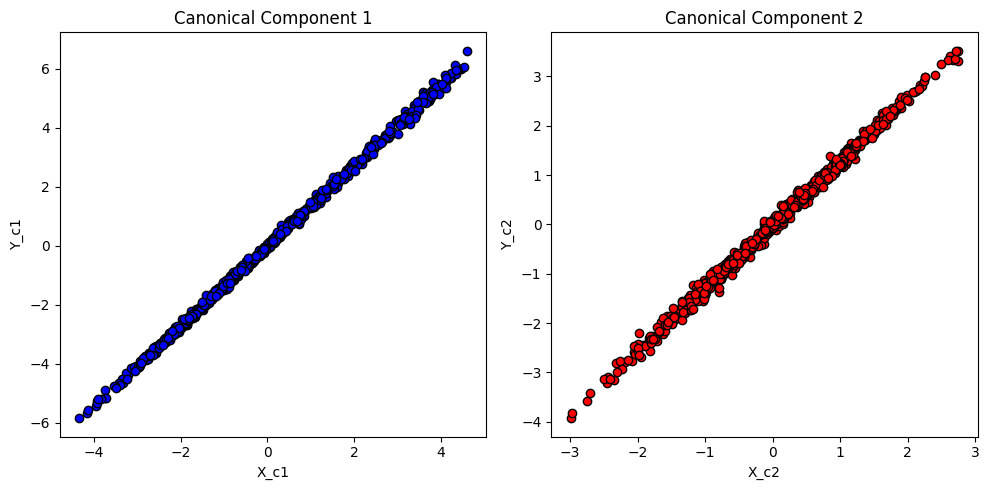

In [316]:
def visualize_cca(X_c, Y_c):
    # Create a scatter plot for each canonical component
    plt.figure(figsize=(10, 5))

    # Component 1
    plt.subplot(1, 2, 1)
    plt.scatter(X_c[:, 0], Y_c[:, 0], color='blue', edgecolor='k')
    plt.title('Canonical Component 1')
    plt.xlabel('X_c1')
    plt.ylabel('Y_c1')

    # Component 2
    plt.subplot(1, 2, 2)
    plt.scatter(X_c[:, 1], Y_c[:, 1], color='red', edgecolor='k')
    plt.title('Canonical Component 2')
    plt.xlabel('X_c2')
    plt.ylabel('Y_c2')

    plt.tight_layout()
    plt.show()

# Call the function with your results
visualize_cca(X_c, Y_c)


## 2-6. Autoencoders


In [317]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

In [321]:
# Assuming df_rs is your dataframe

# Normalize your data (this helps in training the autoencoder)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_rs)

# Size of our encoded representations
encoding_dim = 3  # Feel free to change this value

# Input placeholder
input_data = Input(shape=(df_rs.shape[1],))

# Encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_data)

# Reconstruction of the input
decoded = Dense(df_rs.shape[1], activation='sigmoid')(encoded)

# Full autoencoder model
autoencoder = Model(input_data, decoded)

# Encoder model (for visualization purposes)
encoder = Model(input_data, encoded)

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the autoencoder
autoencoder.fit(data_scaled, data_scaled, epochs=50, batch_size=256, shuffle=True, validation_split=0.2)


Epoch 1/50
3/3 [==============================] - 1s 85ms/step - loss: 1.2578 - val_loss: 1.2167
Epoch 2/50
3/3 [==============================] - 0s 17ms/step - loss: 1.2554 - val_loss: 1.2143
Epoch 3/50
3/3 [==============================] - 0s 35ms/step - loss: 1.2525 - val_loss: 1.2110
Epoch 4/50
3/3 [==============================] - 0s 20ms/step - loss: 1.2489 - val_loss: 1.2069
Epoch 5/50
3/3 [==============================] - 0s 20ms/step - loss: 1.2441 - val_loss: 1.2016
Epoch 6/50
3/3 [==============================] - 0s 17ms/step - loss: 1.2379 - val_loss: 1.1952
Epoch 7/50
3/3 [==============================] - 0s 21ms/step - loss: 1.2305 - val_loss: 1.1876
Epoch 8/50
3/3 [==============================] - 0s 17ms/step - loss: 1.2217 - val_loss: 1.1789
Epoch 9/50
3/3 [==============================] - 0s 17ms/step - loss: 1.2117 - val_loss: 1.1691
Epoch 10/50
3/3 [==============================] - 0s 28ms/step - loss: 1.2006 - val_loss: 1.1585
Epoch 11/50
3/3 [============

23/23 [==============================] - 0s 899us/step


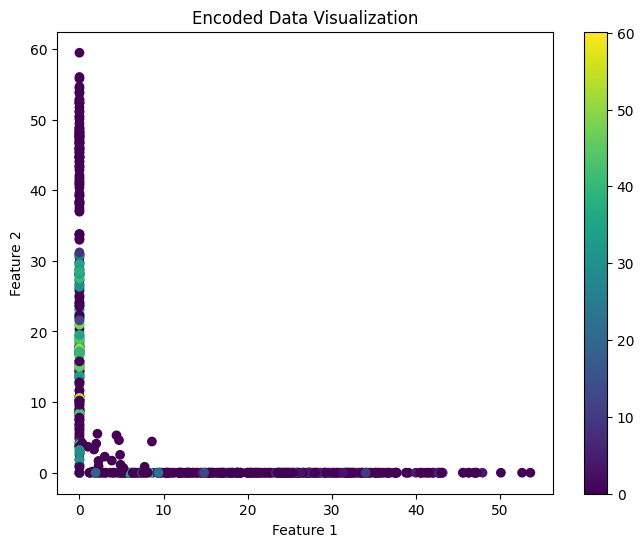

In [322]:
# Encode the data to the reduced dimension
encoded_data = encoder.predict(data_scaled)

def visualize_encoded_data(encoded_data):
    plt.figure(figsize=(8, 6))
    plt.scatter(encoded_data[:, 0], encoded_data[:, 1], c=encoded_data[:, 2], cmap='viridis')
    plt.colorbar()
    plt.title('Encoded Data Visualization')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

visualize_encoded_data(encoded_data)


# **3. MOFA**
This notebook provides an example downstream analysis of a trained MOFA+ model in Python.

Sourced from bioFAM: https://github.com/bioFAM/mofax/blob/master/notebooks/getting_started_pbmc10k.ipynb


## 3-0. Load data

In [323]:
!pip install muon
!pip install mofax
!pip install mofapy2

In [324]:
import scanpy as sc
import muon as mu
import numpy as np
import pandas as pd
import mofax as mofa

In [325]:
# Read Metadata
obs = pd.read_csv("https://raw.githubusercontent.com/sslim0814/laidd/4b94ea205172539c7127fecf42d9df828463a09d/CLL/CCL_metadata.tsv", sep="\t", index_col='sample')

In [326]:
# Read Matrices with data
mods = {}
mods['drugs'] = sc.AnnData(pd.read_csv("https://raw.githubusercontent.com/sslim0814/laidd/4b94ea205172539c7127fecf42d9df828463a09d/CLL/lcc_drugs.tsv", index_col=0, sep='\t').T)
mods['methylation'] = sc.AnnData(pd.read_csv("https://raw.githubusercontent.com/sslim0814/laidd/4b94ea205172539c7127fecf42d9df828463a09d/CLL/lcc_methylation.tsv", index_col=0, sep='\t').T)
mods['rna'] = sc.AnnData(pd.read_csv("https://raw.githubusercontent.com/sslim0814/laidd/4b94ea205172539c7127fecf42d9df828463a09d/CLL/lcc_mrna.tsv", index_col=0, sep='\t').T)
mods['mutations'] = sc.AnnData(pd.read_csv("https://raw.githubusercontent.com/sslim0814/laidd/4b94ea205172539c7127fecf42d9df828463a09d/CLL/lcc_mutation.tsv", index_col=0, sep='\t').T)

In [327]:
mdata = mu.MuData(mods)
mdata.obs = mdata.obs.join(obs)

In [328]:
mdata

MuData object with n_obs × n_vars = 200 × 9627
  obs:	'Diagnosis', 'Gender', 'IGHV', 'Age4Main', 'T5', 'T6', 'treatedAfter', 'died', 'IC50beforeTreatment', 'ConsClust'
  4 modalities
    drugs:	200 x 310
    methylation:	200 x 4248
    rna:	200 x 5000
    mutations:	200 x 69

## 3-1. Integrate data

In [329]:
mu.tl.mofa(mdata, use_obs='union',
           n_factors=15, convergence_mode='medium',
           outfile="models/CLL_union.hdf5")


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Loaded view='drugs' group='group1' with N=200 samples and D=310 features...
Loaded view='methylation' group='group1' with N=200 samples and D=4248 features...
Loaded view='rna' group='group1' with N=200 samples and D=5000 features...
Loaded view='mutations' group='group1' with N=200 samples and D=69 features...


Model options:
- Automatic Relevance Determination prior on the fa

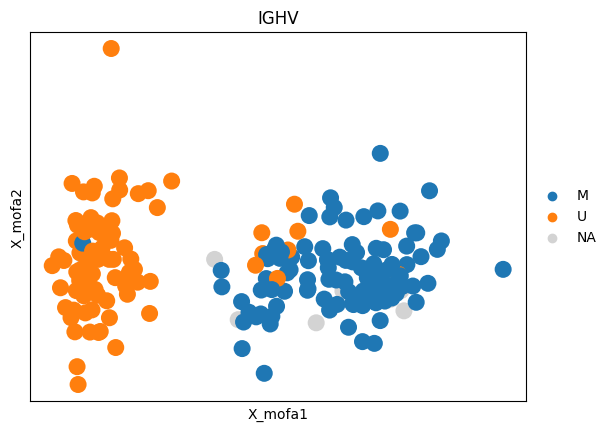

In [330]:
mdata.obs.IGHV_status = mdata.obs.IGHV.astype(str).astype("category").cat.rename_categories({"1.0": "mutated", "0.0": "unmutated"})
mu.pl.mofa(mdata, color="IGHV")

## 3-2. Interpret integrated data

In [331]:
# # Can be used to plot figures with higher resolution:
# from matplotlib import rcParams
# rcParams["figure.dpi"] = 200

In [333]:
model = mofa.mofa_model("models/CLL_union.hdf5")
model

MOFA+ model: CLL union
Samples (cells): 200
Features: 9627
Groups: group1 (200)
Views: drugs (310), methylation (4248), mutations (69), rna (5000)
Factors: 15
Expectations: W, Z

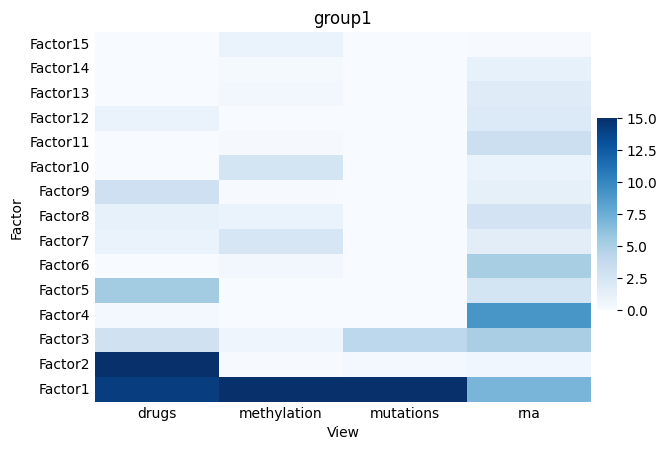

In [334]:
mofa.plot_r2(model, x='View', vmax=15)

### Interpreting factor-wise weights

<Axes: title={'center': 'mutations'}, xlabel='Feature weight'>

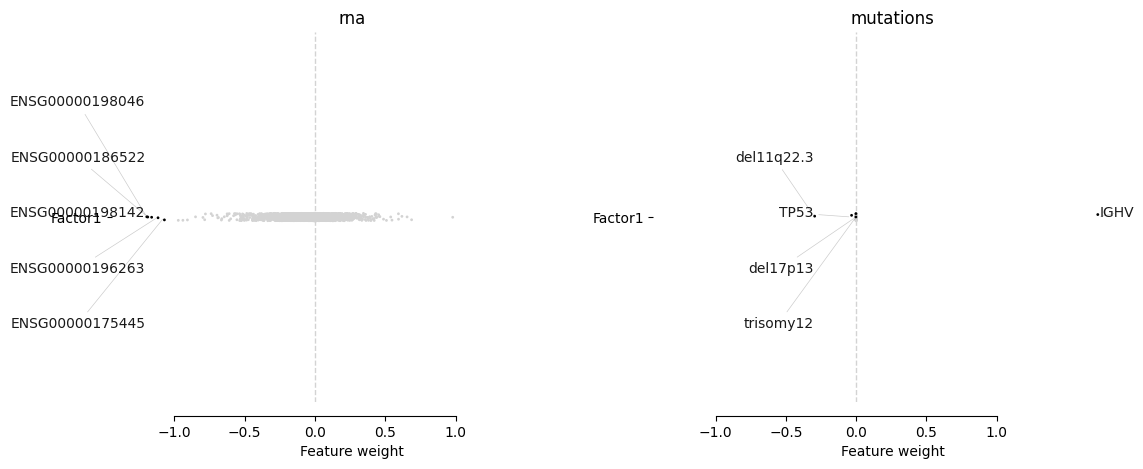

In [336]:
mofa.plot_weights(model, views=['rna', 'mutations'], factors=0, zero_line=True, ncols=2, label_size=10)

<Axes: title={'center': 'IGHV'}, xlabel='factor', ylabel='value'>

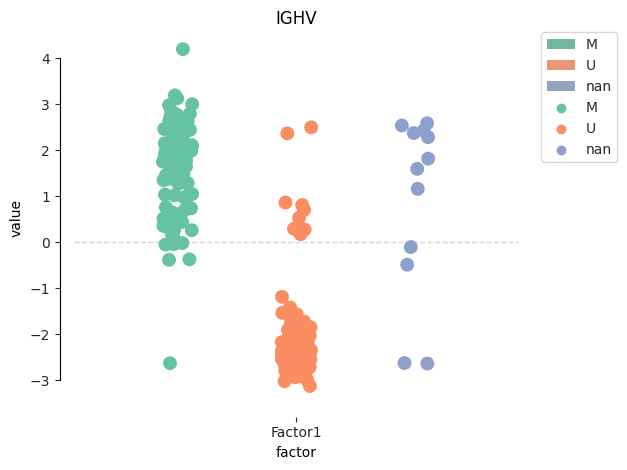

In [337]:
model = mofa.mofa_model("models/CLL_union.hdf5")

model.metadata.IGHV = (
    model.metadata.IGHV.astype(str).
        replace({'1.0': 'mutated', '0.0': 'unmutated'}).
        astype('category')#.cat.reorder_categories(["mutated", "unmutated", "nan"])
)

mofa.plot_factors_violin(model, factors=0, size=10, dots=True, violins=False, color="IGHV", palette="Set2")

<Axes: title={'center': 'drugs'}, xlabel='Feature weight'>

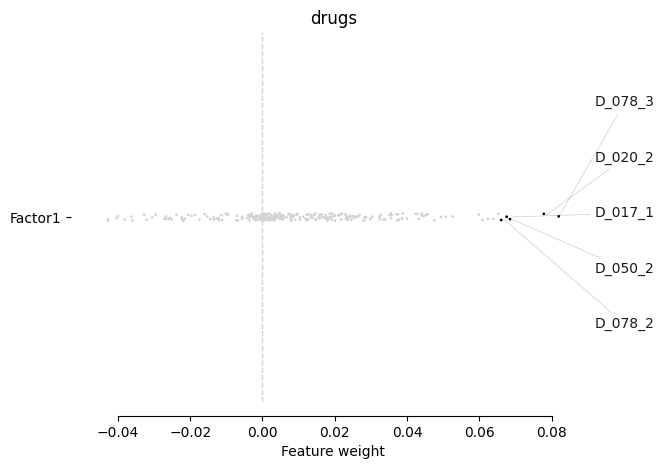

In [338]:
mofa.plot_weights(model, views=['drugs'], factors=0, label_size=10)

<Axes: title={'center': 'rna'}, xlabel='Feature weight'>

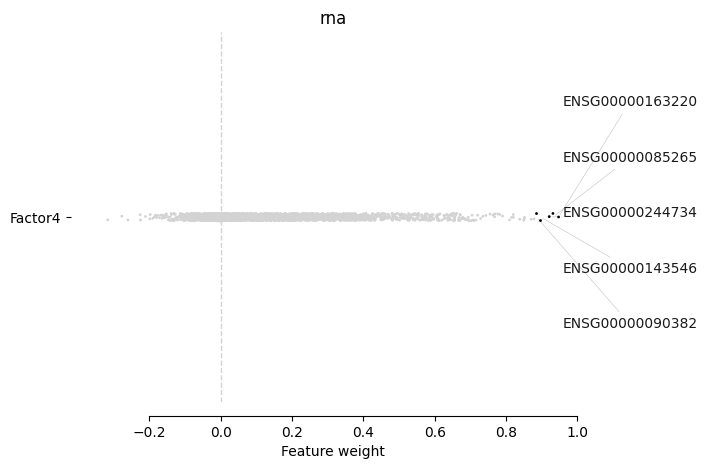

In [339]:
mofa.plot_weights(model, views=['rna'], factors="Factor4", label_size=10)

<Axes: title={'center': 'drugs'}, xlabel='Feature weight'>

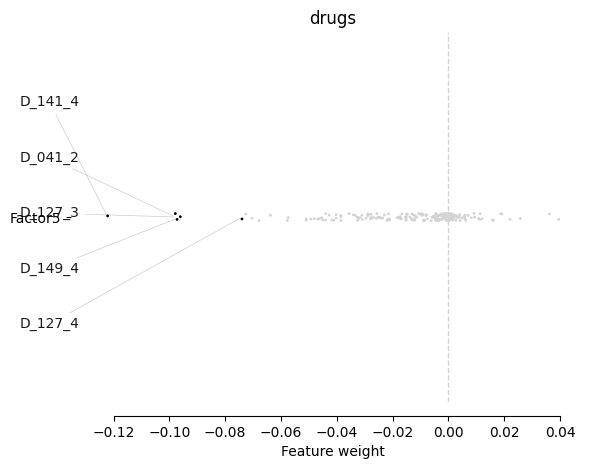

In [340]:
mofa.plot_weights(model, views=['drugs'], factors="Factor5", label_size=10)